In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold, GridSearchCV

from imblearn.over_sampling import SMOTE

import sklearn

plt.rcParams["figure.figsize"] = (10, 10)
plt.rcParams["font.size"] = 15


In [101]:
steam_df = pd.read_csv("Data/steam/games-features-edit.csv")

In [102]:
def select_genres(genres_list, df):
	if len(genres_list) == 2:
		df = df[(df['Genre'] == 'GenreIs' + genres_list[0]) | (df['Genre'] == 'GenreIs' + genres_list[1])]
	elif len(genres_list) == 3:
		df = df[(df['Genre'] == 'GenreIs' + genres_list[0]) | (df['Genre'] == 'GenreIs' + genres_list[1]) | (df['Genre'] == 'GenreIs' + genres_list[2])]
	elif len(genres_list) == 4:
		df = df[(df['Genre'] == 'GenreIs' + genres_list[0]) | (df['Genre'] == 'GenreIs' + genres_list[1]) | (df['Genre'] == 'GenreIs' + genres_list[2]) | (df['Genre'] == 'GenreIs' + genres_list[3])]

	return df

1363


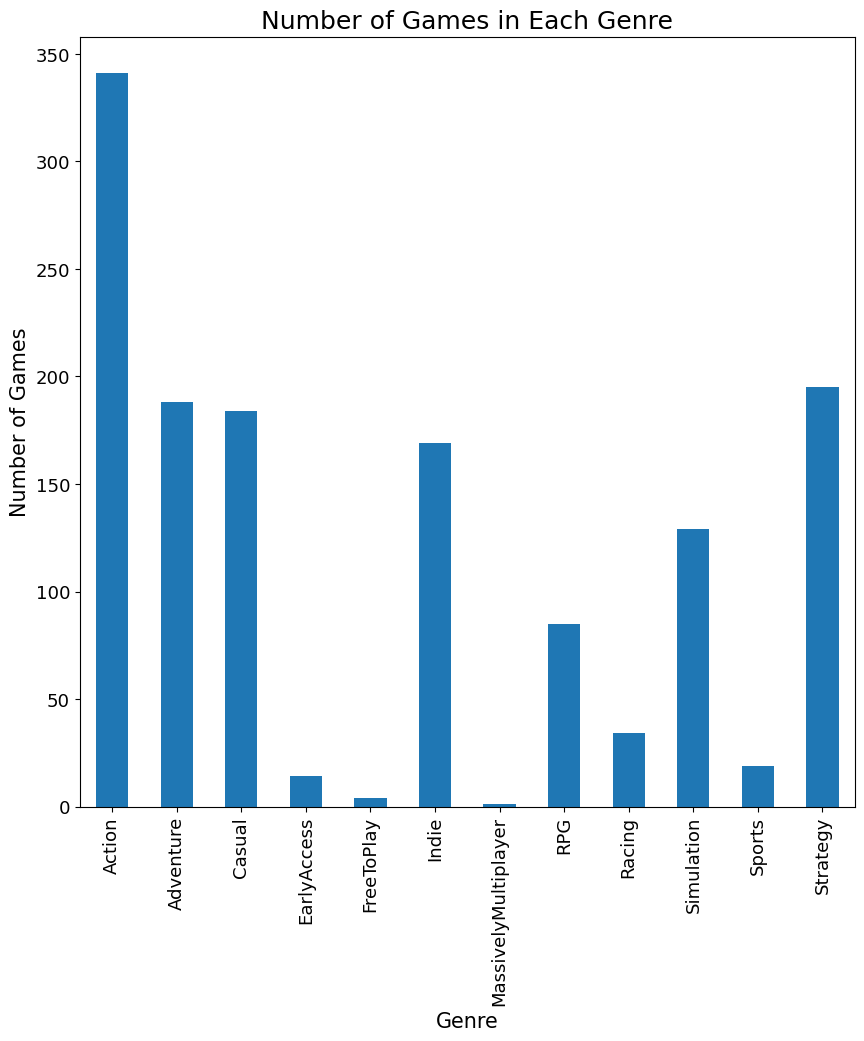

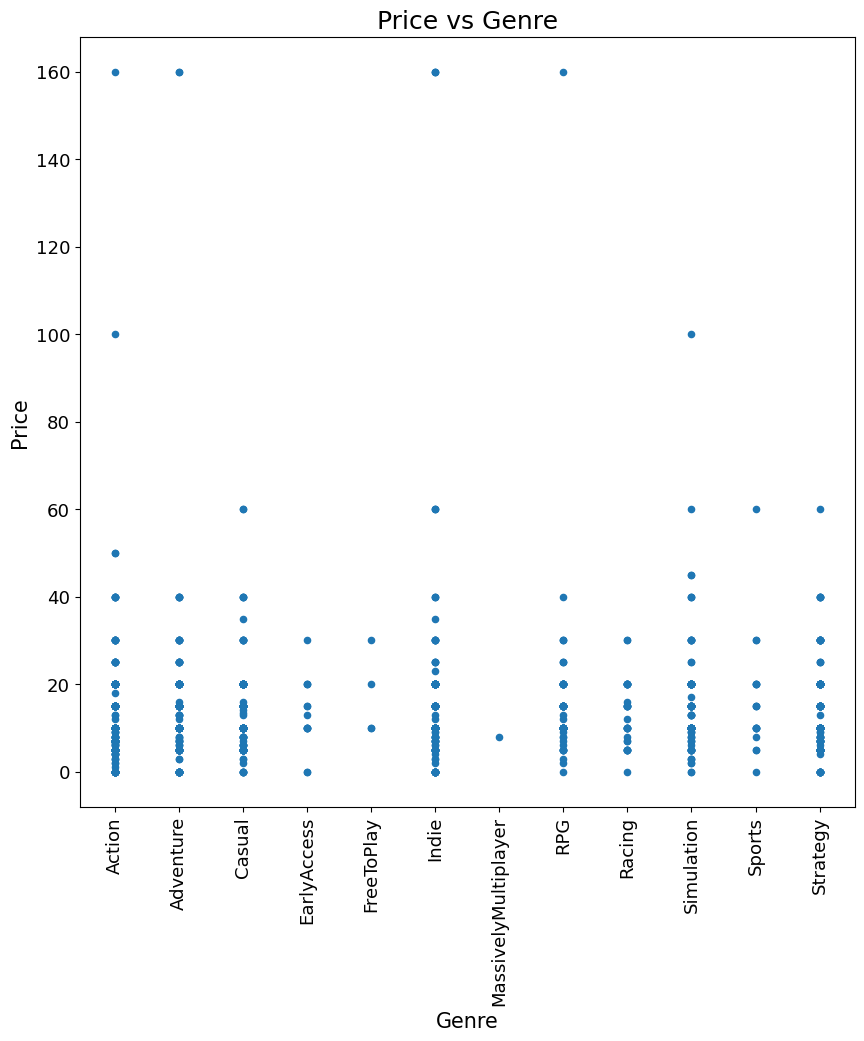

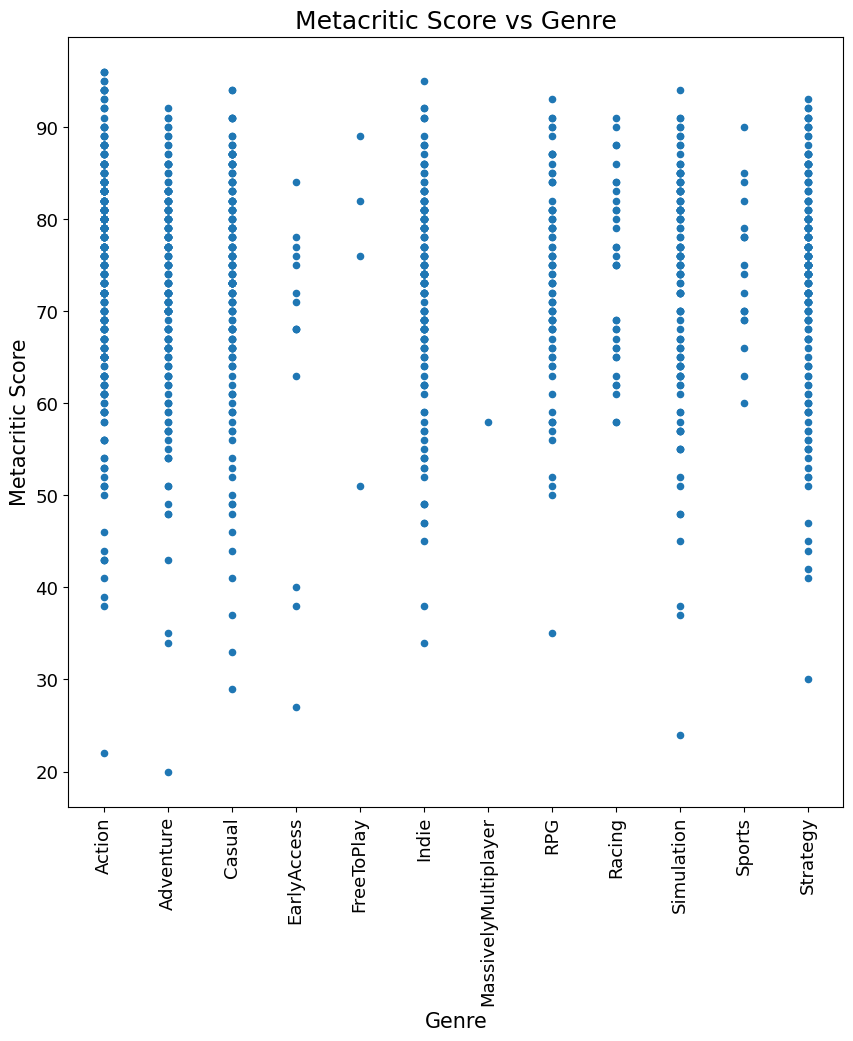

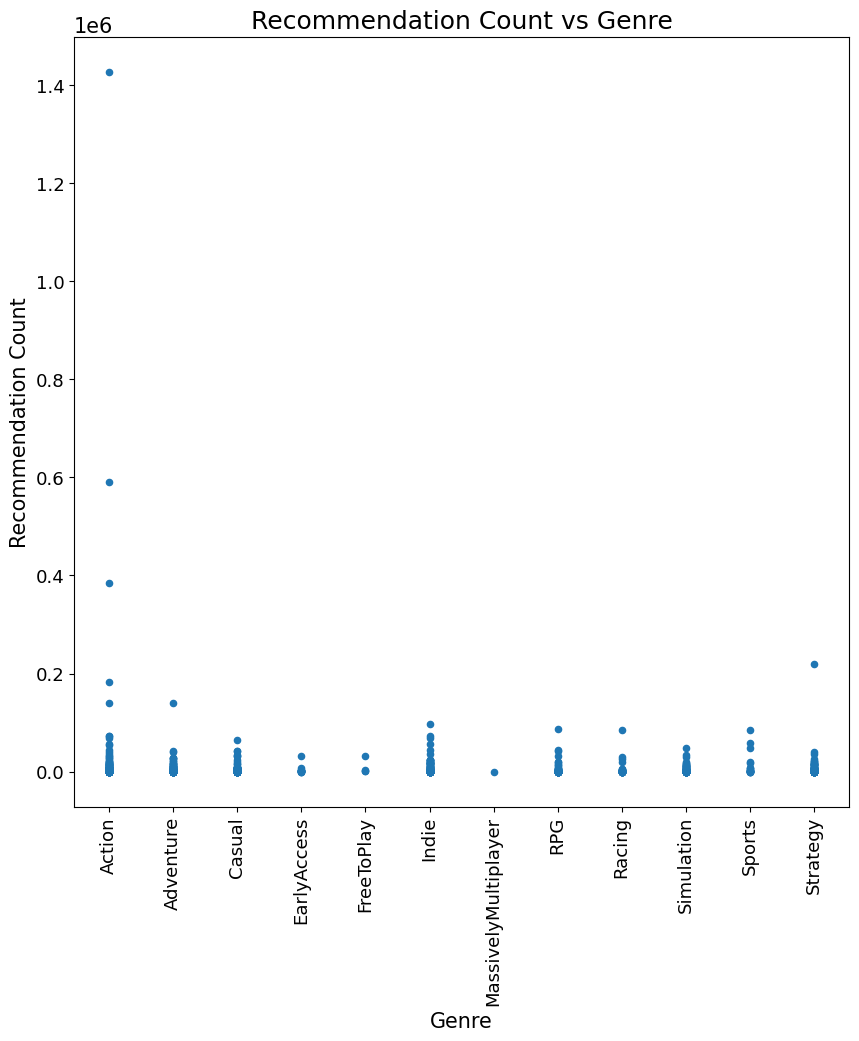

In [103]:
#make a new dataframe with only the ResponseName, ReleaseDate, Metacritic, RecommendationCount, IsFree, and PriceInitial
newDF = steam_df[['ResponseName', 'ReleaseDate', 'Metacritic', 'RecommendationCount', 'IsFree', 'PriceInitial']]

genres = ["GenreIsIndie","GenreIsAction","GenreIsAdventure","GenreIsCasual","GenreIsStrategy","GenreIsRPG","GenreIsSimulation","GenreIsEarlyAccess","GenreIsFreeToPlay","GenreIsSports","GenreIsRacing","GenreIsMassivelyMultiplayer"]
temp = []

rows_genres = []

for index, row in steam_df.iterrows():
	for genre in genres:
		if row[genre] == 1:
			temp.append(genre)
	if len(temp)==1:
		rows_genres.append(temp[0])
	temp = []
	

genresDF = pd.DataFrame(rows_genres, columns = ['Genre'], dtype=str)
df = pd.concat([newDF.copy(), genresDF], axis=1)
df = df[df['Metacritic'] != 0]
df.dropna(subset=['Genre', 'RecommendationCount', 'PriceInitial', 'Metacritic'], inplace=True)

#replace the GenreIs with nothing
df['Genre'] = df['Genre'].str.replace('GenreIs', '')
print(len(df))

genresDF = df.groupby('Genre').size().reset_index(name='counts')
genresDF = genresDF.sort_values(by=['Genre'], ascending=True)

genresDF.plot.bar(x='Genre', y='counts', rot=90, title='Number of Games in Each Genre', fontsize=13, ylabel='Number of Games', legend=False)
df.sort_values(by=['Genre'], inplace=True)


x_tick_labels = df['Genre'].unique().tolist()
df['Genre'] = pd.factorize(df['Genre'])[0]

df.plot.scatter(x='Genre', y='PriceInitial', rot=90, title='Price vs Genre', fontsize=13, ylabel='Price', legend=False)
plt.xticks(np.arange(0, len(x_tick_labels), step=1), x_tick_labels, rotation=90)
plt.show()

df.plot.scatter(x='Genre', y='Metacritic', rot=90, title='Metacritic Score vs Genre', fontsize=13, ylabel='Metacritic Score', legend=False)
plt.xticks(np.arange(0, len(x_tick_labels), step=1), x_tick_labels, rotation=90)
plt.show()

df.plot.scatter(x='Genre', y='RecommendationCount', rot=90, title='Recommendation Count vs Genre', fontsize=13, ylabel='Recommendation Count', legend=False)
plt.xticks(np.arange(0, len(x_tick_labels), step=1), x_tick_labels, rotation=90)
plt.show()


def init_df(genres_to_use, rows_genres, df):
	# print((rows_genres))
	genresDF = pd.DataFrame(rows_genres, columns = ['Genre'], dtype=str)
	genresDF = select_genres(genres_to_use, genresDF)

	df = pd.concat([df, genresDF], axis=1)
	df = df.dropna(subset=['Genre'])
	df = df[df['Metacritic'] != 0]
	df.dropna(subset=['Genre', 'RecommendationCount', 'PriceInitial', 'Metacritic'], inplace=True)

	# print(len(df['Genre']))

	return df



In [93]:

def plot_genres(df):
    #plot the genres and their recommendation counts
    fig, ax = plt.subplots(1,3)
    ax[0].scatter(df['Genre'], df['PriceInitial'])
    ax[0].set_xlabel('Genre')
    ax[0].set_ylabel('Price ($)')
    ax[1].scatter(df['Genre'], df['RecommendationCount'])
    ax[1].set_xlabel('Genre')
    ax[1].set_ylabel('Recommendation Count')
    ax[2].scatter(df['Genre'], df['Metacritic'])
    ax[2].set_xlabel('Genre')
    ax[2].set_ylabel('Metacritic Score')
    plt.show()


In [94]:
#split the data into training and testing sets
def train_set(df):
    X = df[['Metacritic', 'RecommendationCount', 'PriceInitial']]
    y = df['Genre']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)

    sm = SMOTE(random_state=42)
    X_train, y_train = sm.fit_resample(X_train, y_train)

    # create a k-fold cross validation iterator
    kfold = KFold(n_splits=5, random_state=42, shuffle=True)

    # define the grid of hyperparameters to search over
    param_grid = {
        "n_estimators": [100, 200, 300, 400, 500],
        "max_depth": [5, 10, 15, 20, 25],
        "min_samples_split": [2, 5, 10, 15, 20],
        "random_state": [42]
    }

    # create the random forest classifier
    clf = RandomForestClassifier()

    # create a grid search object to find the best hyperparameters
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=kfold, n_jobs=-1)

    # fit the grid search on the data
    grid_search.fit(X_train, y_train)


    # print the best hyperparameters found
    return grid_search.best_estimator_, X_test, y_test, X_train, y_train


In [95]:

def random_forest(genres_to_use, rows_genres, newDF):
    df = init_df(genres_to_use, rows_genres, newDF)
    
    rfc, X_test, y_test, X_train, y_train = train_set(df)
    cf = RandomForestClassifier(n_estimators=rfc.n_estimators, random_state=rfc.random_state, max_depth=rfc.max_depth, min_samples_split=rfc.min_samples_split)

    abc = AdaBoostClassifier(estimator=cf, n_estimators=100, learning_rate=1, random_state=42)
    cf.fit(X_train, y_train)
    abc.fit(X_train, y_train)
    base_train = accuracy_score(y_train, cf.predict(X_train))
    base_test = accuracy_score(y_test, cf.predict(X_test))

    ada_train = accuracy_score(y_train, abc.predict(X_train))
    ada_test = accuracy_score(y_test, abc.predict(X_test))

    est = cf.estimators_[0]
    t = tree.export_text(est, feature_names=['Metacritic', 'RecommendationCount', 'PriceInitial'])
    print(t)
    return base_train, base_test, ada_train, ada_test


In [96]:
big_genres = ['Action', 'Adventure', 'Casual', 'Indie', 'Strategy']
base_train_acc = []
ada_train_acc = []
base_test_acc = []
ada_test_acc = []
for genre in big_genres:
    for genre2 in big_genres:
        if genre < genre2:
            print(f'{genre} vs {genre2}')
            train1, test1, train2, test2 = random_forest([genre, genre2], rows_genres, newDF)
            base_train_acc.append(train1)
            base_test_acc.append(test1)
            ada_train_acc.append(train2)
            ada_test_acc.append(test2)
            print()



# Define the training and testing accuracies


Action vs Adventure
|--- Metacritic <= 86.50
|   |--- RecommendationCount <= 107.00
|   |   |--- PriceInitial <= 2.49
|   |   |   |--- class: 1.0
|   |   |--- PriceInitial >  2.49
|   |   |   |--- PriceInitial <= 8.11
|   |   |   |   |--- PriceInitial <= 6.14
|   |   |   |   |   |--- Metacritic <= 71.50
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- Metacritic >  71.50
|   |   |   |   |   |   |--- Metacritic <= 80.00
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |--- Metacritic >  80.00
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- PriceInitial >  6.14
|   |   |   |   |   |--- class: 0.0
|   |   |   |--- PriceInitial >  8.11
|   |   |   |   |--- Metacritic <= 77.00
|   |   |   |   |   |--- PriceInitial <= 13.99
|   |   |   |   |   |   |--- PriceInitial <= 10.28
|   |   |   |   |   |   |   |--- Metacritic <= 53.50
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |--- Metacritic >  53.50
|   |   |   |  

[0.983271375464684, 0.9540441176470589, 0.9743589743589743, 0.8444444444444444, 0.9033333333333333, 0.99, 0.9551282051282052, 0.7465277777777778, 0.9363057324840764, 0.8726708074534162]
[0.9869888475836431, 0.9871323529411765, 0.9908424908424909, 0.9888888888888889, 0.9966666666666667, 0.99, 0.9903846153846154, 0.9930555555555556, 0.9840764331210191, 0.9906832298136646]


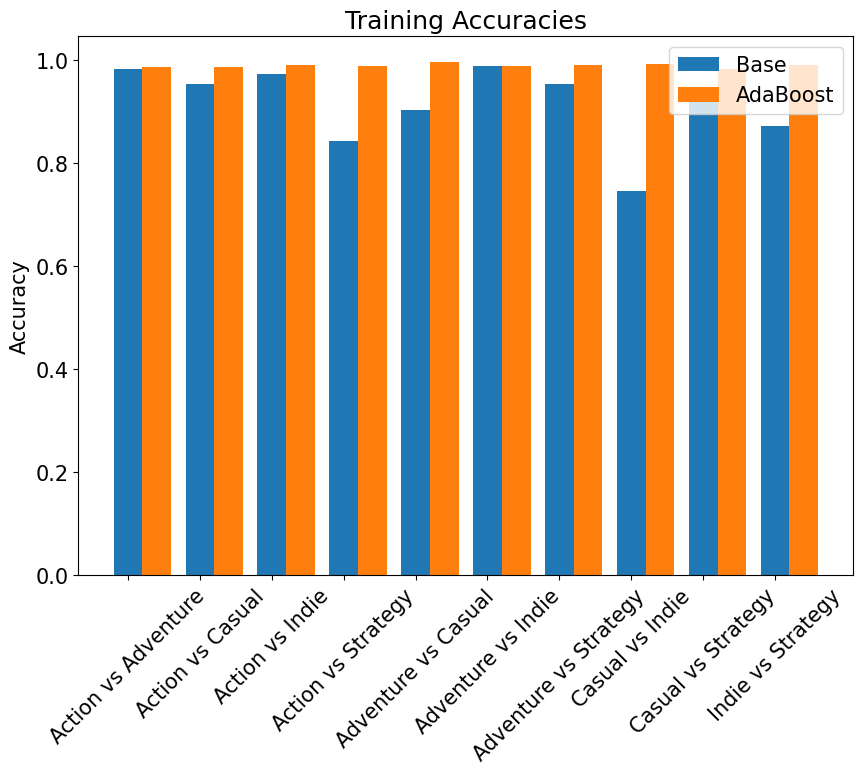

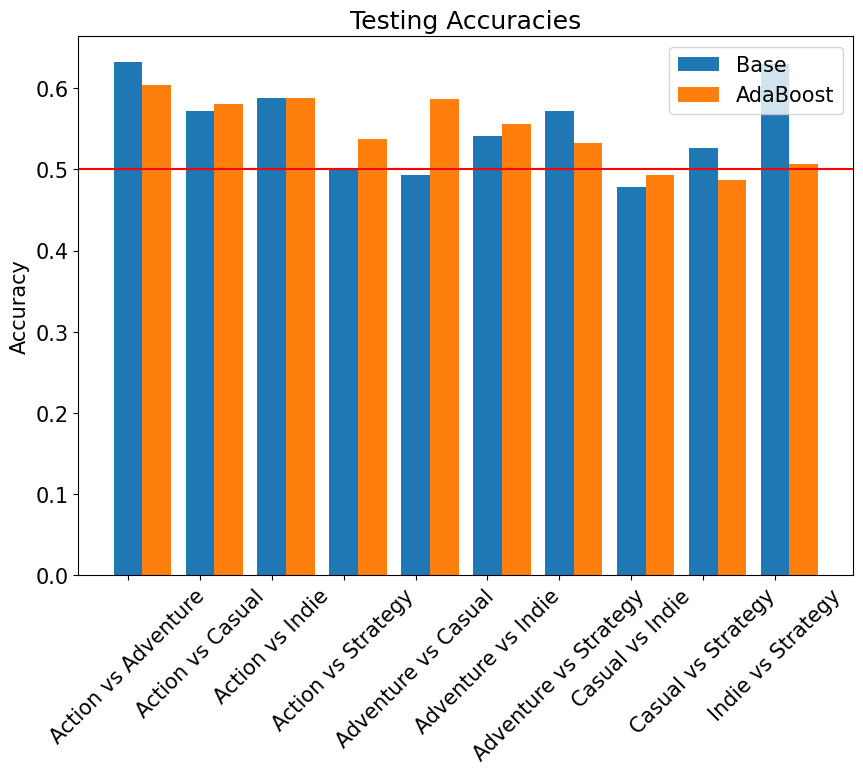

In [97]:

plt.figure(figsize=(10, 7))
plt.bar(range(1, 11), base_train_acc, width=0.4, label='Base')
# plt.bar(range(1, 11), ada_train_acc, bottom=base_train_acc, label='AdaBoost')
plt.bar([x + 0.4 for x in range(1, 11)], ada_train_acc, width=0.4, label='AdaBoost')

# Set the x-axis labels
plt.xticks(np.arange(1, 11, 1), ['Action vs Adventure', 'Action vs Casual', 'Action vs Indie', 'Action vs Strategy', 'Adventure vs Casual', 'Adventure vs Indie', 'Adventure vs Strategy', 'Casual vs Indie', 'Casual vs Strategy', 'Indie vs Strategy'], rotation=45)
plt.ylabel('Accuracy')
# Add a legend and a title
plt.legend()
plt.title('Training Accuracies')

# Show the plot
plt.show()

plt.figure(figsize=(10, 7))
plt.bar(range(1, 11), base_test_acc, width=0.4, label='Base')
# plt.bar(range(1, 11), ada_train_acc, bottom=base_train_acc, label='AdaBoost')
plt.bar([x + 0.4 for x in range(1, 11)], ada_test_acc, width=0.4, label='AdaBoost')

# Set the x-axis labels
plt.xticks(np.arange(1, 11, 1), ['Action vs Adventure', 'Action vs Casual', 'Action vs Indie', 'Action vs Strategy', 'Adventure vs Casual', 'Adventure vs Indie', 'Adventure vs Strategy', 'Casual vs Indie', 'Casual vs Strategy', 'Indie vs Strategy'], rotation=45)
plt.ylabel('Accuracy')
# Add a legend and a title
plt.legend()
plt.title('Testing Accuracies')

#draw a line at 0.5
plt.axhline(y=0.5, color='r', linestyle='-')
# Show the plot
plt.show()
